<a href="https://colab.research.google.com/github/Chocoding1/Machine_Learning_Deep_Learning/blob/main/%5BDeep%20Learning%5D%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN, 오토인코더

GAN : 생성적 적대 신경망(Generative Adversarial Networks)
- 딥러닝의 원리를 활용해 가상 이미지를 생성하는 알고리즘
- 진짜같은 가짜를 만들기 위해 GAN 알고리즘 내부에서 '적대적' 경합 진행
- 생성자(Generator) : 가짜 만드는 파트
- 판별자(Discriminator) : 진위를 가려내는 파트

여기서는 페이스북의 DCGAN(Deep Convolutional GAN)을 사용할 예정
- DCGAN : 컨볼루션 신경망(CNN)을 GAN에 적용한 알고리즘

## 생성자(Generator)

- 처음에는 랜덤한 픽셀 값으로 채워진 가짜 이미지로 시작해서 판별자의 판별 결과에 따라 지속적으로 업데이트하며 점차 원하는 이미지 생성
- DCGAN에서 사용되는 CNN은 앞서 나온 것과 달리 optimizer(최적화)나 컴파일 과정 필요 x -> 판별과 학습이 생성자에서 일어나는 것이 아니기 때문
- 풀링(pooling) 과정 없고, 패딩(padding) 과정만 포함 -> 입력 크기와 출력 크기를 동일하게 맞추기 위해(이미지가 컨볼루션 층을 지나면 크기가 줄어들기 때문)
- 패딩을 통해 이미지 크기를 조절해야 하는 정확한 이유는 판별자가 비교할 '진짜'와 똑같은 크기가 되어야 하기 때문(padding='same' : 입력과 출력의 크기가 다를 경우 자동으로 크기 확장(0으로 채움))
- 배치 정규화(Batch Normalization) : 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치하는 것으로, 다음 층으로 입력될 값을 일정하게 재배치 하는 역할 -> 층의 개수가 늘어나도 안정적인 학습 진행 가능
- 생성자의 활성화 함수는 relu 함수, 판별자로 넘겨주기 직전에는 tanh 함수 사용(tanh 함수 : 출력값을 -1~1 사이로 조정)
- 판별자에 입력될 MNIST 손글씨 픽셀 범위도 -1~1로 맞추면 판별 조건이 모두 갖춰진다.

In [ ]:
# Generator 코드
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2))) # 1
generator.add(BatchNormalization()) # 2
generator.add(Reshape(7, 7, 128)) # 3
generator.add(UpSampling2D()) # 4
generator.add(Conv2D(64, kernel_size=5, padding='same')) # 5
generator.add(BatchNormalization()) # 6
generator.add(Activation(LeakyReLU(0.2))) # 7
generator.add(UpSampling2D()) # 8
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh')) # 9

1. 128 : 임의로 정한 노드 수<br>
input_dim=100 : 임의로 100차원 크기의 랜덤 벡터 입력<br>
7 * 7 : 모델 구조를 보면 UpSampling2D()가 있는데, 이는 가로세로 크기를 두 배씩 늘려준다. MNIST 이미지 크기는 28x28, 즉 7x7 이미지를 총 2번 UpSampling2D()하여 28x28로 만들어주는 것(이렇게 작은 크기의 이미지를 점점 늘려 가면서 컨볼루션 층을 지나치게 하는 것이 DCGAN의 특징)<br>
keras는 UpSampling과 Conv2D를 합쳐놓은 Conv2DTranspose() 함수도 제공
2. 데이터의 배치를 정규 분포로 만든다.
3. convolution layer가 받아들일 수 있는 형태로 바꿔주는 코드(Conv2D() 함수의 input_shape 부분에 들어갈 형태로 지정)
4. 이미지 가로세로 길이 2배 증가
5. 컨볼루션 과정(kernel 64개)
6. 2와 동일
7. GAN에서는 기존의 ReLU()를 사용할 경우 학습이 불안정해지는 경우가 많아, LeakyReLU() 사용 - LeakyReLU(0.2) : 0보다 작을 경우 x0.2
8. 4와 동일
9. 판별자로 넘겨주기 직전 컨볼루션 과정(kernel 1개, tanh() 사용)

## 판별자(Discriminator)

- 생성자에서 넘어온 이미지가 진짜인지 가짜인지 판별
- 판별자는 CNN의 구조를 그대로 가지고 와서 만들면 된다. (CNN이란 원래 무언가를(ex) 개와 고양이 사진) 구별하는데 최적화된 알고리즘이기 때문)
- 진짜(1) or 가짜(0)를 판별하는 것이므로 loss 함수는 binary_crossentropy, optimizer는 adam 사용
- CNN 파트에서 사용한 Dropout, 정규화, padding 그대로 사용
<br>
<br>
- <b>주의할 점 : 판별자는 진위 여부만 가릴 뿐, 학습을 해서는 x</b>
- 판별자가 얻은 가중치는 생성자로 넘겨주어 생성자가 업데이트된 이미지를 만들도록 해야 한다.
- 따라서 판별자를 만들 때는 가중치를 저장하는 학습 기능을 비활성화해야 한다.

In [ ]:
# Discriminator 코드
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same')) # 1
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten()) # 2
discriminator.add(Dense(1, activation='sigmoid')) # 3

discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False # 4

1. kernel 수 : 64개<br>
strides : kernel 윈도우를 몇 칸씩 이동시킬지 설정하는 옵션(여기서는 두 칸씩 이동)<br>
kernel 윈도우를 여러 칸 움직이는 이유 : 가로세로 크기가 더 줄어들어 새로운 특징을 뽑아주는 효과 발생<br>
생성자에서는 업샘플링을 통해 가로세로 길이를 28로 늘렸지만, 판별자는 진짜, 가짜만 구분하면 되기 때문에 그럴 필요 x (strides나 Dropout 등의 차원을 줄여주는 기능을 적극 활용하여 CNN 본래의 목적을 달성하면 된다.)
2. 2차원으로 진행된 과정을 1차원으로 변경
3. 0, 1을 가려내야 하기 때문에 sigmoid() 함수 사용
4. 판별이 끝나고 판별자 스스로 학습되지 않게끔 학습 기능 비활성화

## 적대적 신경망 실행

- 생성자와 판별자를 연결하고 학습을 진행하며 기타 여러 가지 옵션을 설정하는 단계
- 생성자의 가짜 이미지를 판별자가 제대로 구별할 수 없게 되어 정화도가 0.5에 가까워지면 생성자는 학습 종료

In [ ]:
# 생성자-판별자 연결 모델 생성 코드
ginput = Input(shape=(100,)) # 랜덤한 100개의 벡터를 keras의 Input() 함수에 넣어 생성자에 입력할 ginput 생성
dis_output = discriminator(generator(ginput)) # 초기 랜덤 벡터를 생성자에 넣어 나온 이미지(28x28)를 판별자가 판별한 결과
gan = Model(ginput, dis_output) # keras의 Model() 함수를 이용해 ginput 값과 dis_output 값을 넣어 gan이라는 이름의 새로운 모델 생성
gan.compile(loss='binary_crossentropy', optimizer='adam') # gan 모델 컴파일

In [ ]:
# 훈련 실행 함수 코드
def gan_train(epoch, batch_size, saving_interval):
  # MNIST 데이터 불러오기
  (X_train, _), (_, _) = mnist.load_data() # 테스트 과정을 필요 없고, 이미지만 사용할 것이기 때문에 X_train만 호출

  # 가로 28픽셀, 세로 28픽셀, 흑백이므로 1
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

  # 픽셀 값을 -1~1 사이의 값으로 변경 (이 때문에 생성자에서 마지막에 tanh() 함수를 사용한 것)
  X_train = (X_train - 127.5) / 127.5

  # batch_size만큼 MNIST 손글씨 이미지를 랜덤하게 불러와 판별자에 집어넣기
  # batch_size : 한 번에 몇 개의 실제 이미지와 몇 개의 가상 이미지를 판별자에 넣을지 결정
  true = np.ones((batch_size, 1)) # 판별자에 넣을 label (실제 이미지이므로 label : 1)
  # 실제 이미지를 랜덤하게 선택해 가져오기
  idx = np.random.randint(0, X_train.shape[0], batch_size) # np.random.randint(a, b, c) : a부터 b까지 숫자 중 하나를 랜덤하게 선택하는 과정을 c번 반복
  imgs = X_train[idx] # 선택된 인덱스의 사진 가져오기
  # 진짜 이미지 판별 실행(학습이 계속될 수록 진짜라는 레이블을 붙인 이미지들에 대한 예측 결과가 참으로 나올 것)
  d_loss_real = discriminator.train_on_batch(imgs, true) # train_on_batch(x, y) : x(입력 값)와 y(레이블)를 받아서 딱 한 번 학습을 실시해 모델 업데이트

  # 가상의 이미지 판별자에 집어넣기
  fake = np.zeros((batch_size, 1)) # 가상의 이미지이므로 label : 0
  # 생성자에 집어넣을 가상 이미지 생성(정수가 아니기 때문에 np.random.normal() 함수 사용)
  noise = np.random.normal(0, 1, (batch_size, 100)) # np.random.normal(a, b, c) : a부터 b까지 실수 중 c개 랜덤 뽑기(여기서는 100차원 크기 랜덤벡터 생성)
  gen_imgs = generator.predict(noise) # 생성된 랜덤 벡터 생성자에 넣어 가짜 이미지 생성
  # # 가짜 이미지 판별 실행(학습이 계속될 수록 가짜라는 레이블을 붙인 이미지들에 대한 예측 결과가 거짓으로 나올 것)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

  # 이러면 실제 이미지를 넣은 d_loss_real과 가상 이미지를 넣은 d_loss_fake가 판별자 안에서 번갈아 가며 진위를 판단
  # 판별자 loss 계산
  d_loss = np.sum(d_loss_real, d_loss_fake) * 0.5 # 각각 계산되는 오차의 평균 계산하여 d_loss 정의

  # 생성자 loss 계산(판별자와 생성자를 연결해서 만든 gan 모델을 이용해 생성자 오차 계산)
  g_loss = gan.train_on_batch(noise, true)

  # 생성자, 판별자 오차 출력
  print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_7 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_8 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1078146 (4.11 MB)
Trainable params: 852609 (3.25 MB)
Non-trainable params: 225537 (881.00 KB)
_________________________________________________________________


1/1 [==============================] - 0s 284ms/step
epoch:0  d_loss:0.7068  g_loss:0.4216
1/1 [==============================] - 0s 84ms/step
epoch:1  d_loss:0.5321  g_loss:0.1676
1/1 [==============================] - 0s 90ms/step
epoch:2  d_loss:0.5151  g_loss:0.0932
1/1 [==============================] - 0s 83ms/step
epoch:3  d_loss:0.5033  g_loss:0.1298
1/1 [==============================] - 0s 82ms/step
epoch:4  d_loss:0.4631  g_loss:0.2488
1/1 [==============================] - 0s 100ms/step
epoch:5  d_loss:0.4640  g_loss:0.4064
1/1 [==============================] - 0s 82ms/step
epoch:6  d_loss:0.4757  g_loss:0.4952
1/1 [==============================] - 0s 83ms/step
epoch:7  d_loss:0.4894  g_loss:0.5332
1/1 [==============================] - 0s 100ms/step
epoch:8  d_loss:0.4628  g_loss:0.5970
1/1 [==============================] - 0s 87ms/step
epoch:9  d_loss:0.5017  g_loss:0.5685
1/1 [==============================] - 0s 87ms/step
epoch:10  d_loss:0.5491  g_loss:0.4660
1/1 [=

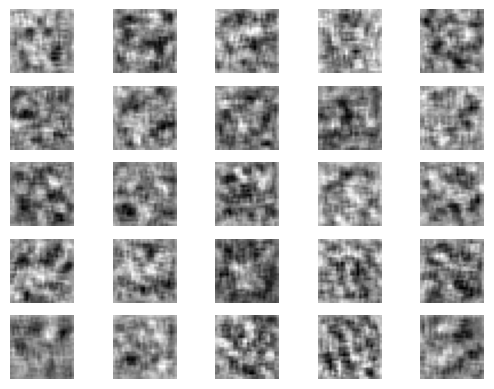

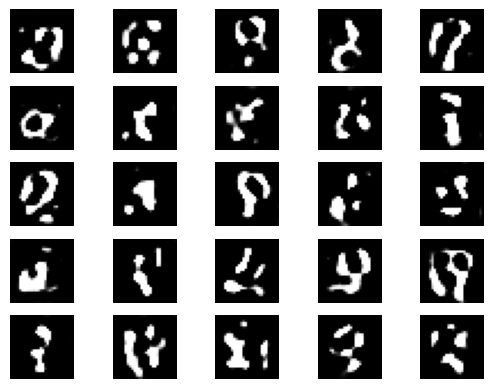

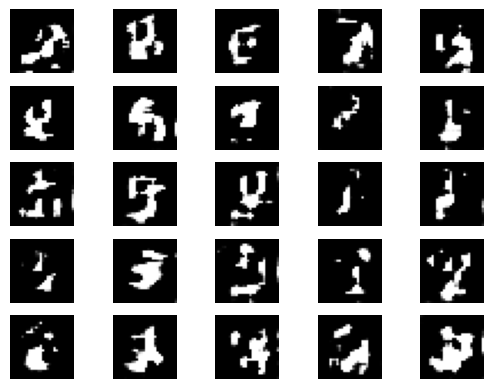

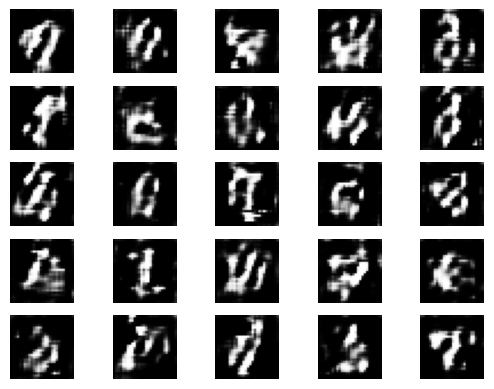

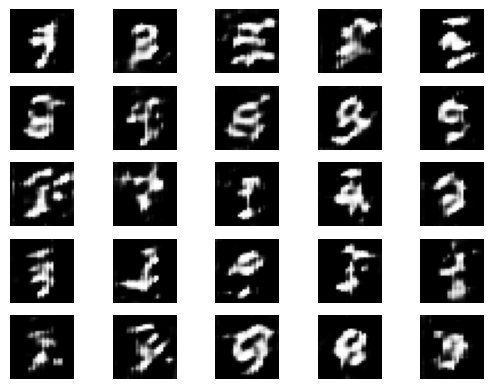

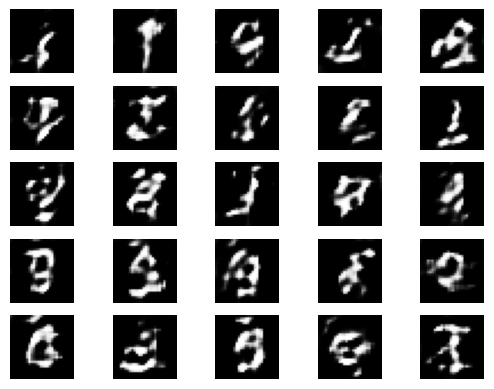

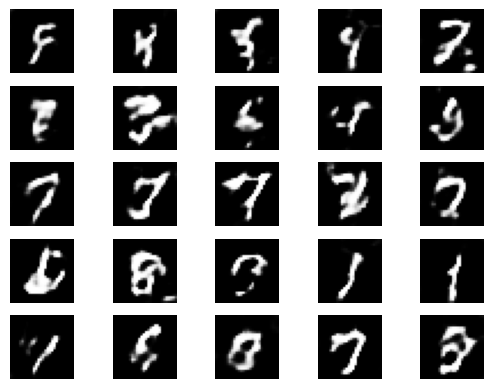

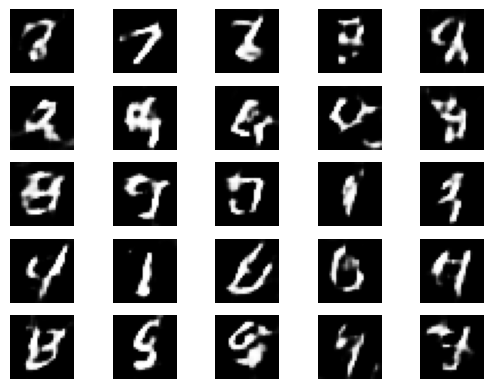

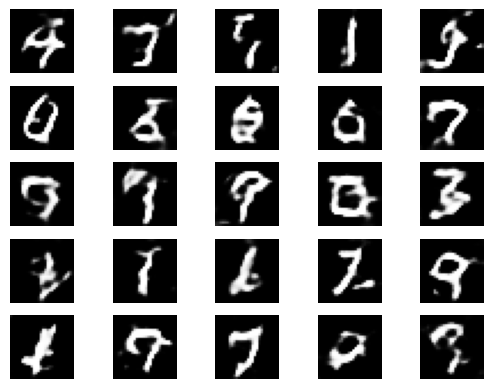

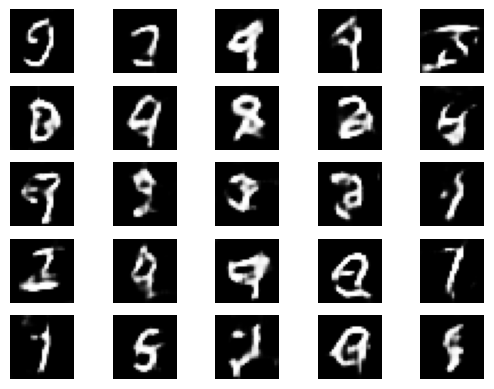

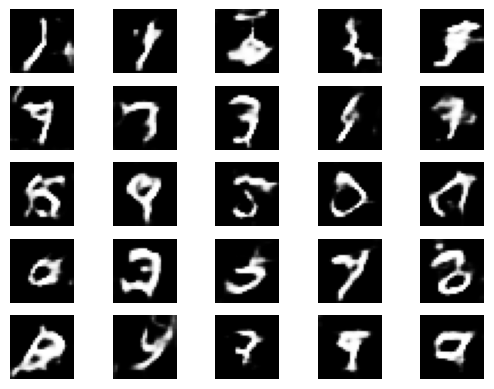

In [5]:
# GAN 전체 코드
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

# Generator Model
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2))) # vector size : 100 -> 784*7*7
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128))) # image size : 7x7 (128개)
generator.add(UpSampling2D()) # image size : 14x14
generator.add(Conv2D(64, kernel_size=5, padding='same')) # 14x14 (64개)
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D()) # image size : 28x28 (64개)
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh')) # 28x28 (1개)

# Discriminator Model
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same')) # image size : 28x28 (64개)
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same')) # image size : 28x28 (128개)
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten()) # vector size : 28*28 (128개)
discriminator.add(Dense(1, activation='sigmoid')) # 0 or 1 분류
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

# GAN Model(Generator + Discriminator)
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

# 신경망 실행 함수
def gan_train(epoch, batch_size, saving_interval):
  # 이미지 데이터 불러오기
  (X_train, _), (_, _) = mnist.load_data()

  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

  X_train = (X_train - 127.5) / 127.5

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    # 실제 데이터 판별자에 입력
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    # 가상의 이미지 판별자에 집어넣기
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    # 판별자 loss 계산
    d_loss = np.add(d_loss_real, d_loss_fake) * 0.5
    # 생성자 loss 계산
    g_loss = gan.train_on_batch(noise, true)

    # 생성자, 판별자 오차 출력
    print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

    # 중간 과정 이미지로 저장
    # 정해진 인터벌만큼 학습되면 그 때 만든 이미지를 gan_images 폴더에 저장
    if i % saving_interval == 0:
      # row, col = 5
      noise = np.random.normal(0, 1, (25, 100))
      gen_imgs = generator.predict(noise)

      # rescale images 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5

      fig, axs = plt.subplots(5, 5)
      count = 0
      for j in range(5):
        for k in range(5):
          axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
          axs[j, k].axis('off')
          count += 1
      fig.savefig('./gan_mnist_%d.png' % i)

# 2000 + 1 하는 것 주의(2000번째 결과를 출력하기 위해(?))
gan_train(2001, 32, 200)

## 오토인코더(Auto-Encoder, AE)

- 딥러닝을 이용해 가상의 이미지를 만드는 또 하나의 유명한 알고리즘
- GAN이 세상에 존재하지 않는 완전한 가상의 것을 만드는 반면, 오토인코더는 입력 데이터의 특징을 효율적으로 담아낸 이미지를 만든다.
- 데이터의 특징을 잘 담아내기 때문에 학습 데이터 수가 부족하더라도 효과적인 성능을 기대할 수 있다.
- 인코딩과 디코딩 과정을 거친다.

In [ ]:
# 생성자 모델 만들기
autoencoder = Sequential()

# Encoding part(입력된 값의 차원을 축소)
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu')) # output shape : (28, 28, 16)
autoencoder.add(MaxPooling2D(pool_size=2, padding='same')) # 입력 크기 축소 / # output shape : (14, 14, 16)
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same')) # output shape : (14, 14, 8)
autoencoder.add(MaxPooling2D(pool_size=2, padding='same')) # 입력 크기 축소 / output shape : (7, 7, 8)
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu')) # output shape : (4, 4, 8)

# Decoding part(다시 차원을 점차 늘려 입력 값과 똑같은 크기의 출력 값을 내보냄)
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu')) # output shape : (4, 4, 8)
autoencoder.add(UpSampling2D()) # output shape : (8, 8, 8)
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu')) # output shape : (8, 8, 8)
autoencoder.add(UpSampling2D()) # output shape : (16, 16, 8)
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu')) # output shape : (14, 14, 16) -> padding='same' 없음
autoencoder.add(UpSampling2D()) # output shape : (28, 28, 16)
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', acitvation='sigmoid')) # output shape : (28, 28, 1)

Epoch 1/50
469/469 [==============================] - 76s 159ms/step - loss: 0.2061 - val_loss: 0.1356
Epoch 2/50
469/469 [==============================] - 68s 144ms/step - loss: 0.1260 - val_loss: 0.1178
Epoch 3/50
469/469 [==============================] - 67s 143ms/step - loss: 0.1154 - val_loss: 0.1109
Epoch 4/50
469/469 [==============================] - 66s 141ms/step - loss: 0.1102 - val_loss: 0.1068
Epoch 5/50
469/469 [==============================] - 66s 141ms/step - loss: 0.1067 - val_loss: 0.1037
Epoch 6/50
469/469 [==============================] - 69s 148ms/step - loss: 0.1039 - val_loss: 0.1013
Epoch 7/50
469/469 [==============================] - 67s 142ms/step - loss: 0.1018 - val_loss: 0.0995
Epoch 8/50
469/469 [==============================] - 69s 147ms/step - loss: 0.0999 - val_loss: 0.0976
Epoch 9/50
469/469 [==============================] - 65s 138ms/step - loss: 0.0984 - val_loss: 0.0970
Epoch 10/50
469/469 [==============================] - 66s 142ms/step - l

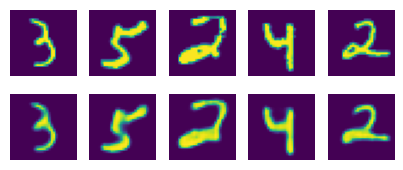

In [7]:
# Auto-Encoder 전체 코드
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import matplotlib.pyplot as plt
import numpy as np

# MNIST 데이터셋 로드
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# Generator Model 생성
autoencoder = Sequential()

# Encoding part
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu')) # output shape : (28, 28, 16)
autoencoder.add(MaxPooling2D(pool_size=2, padding='same')) # 입력 크기 축소 / # output shape : (14, 14, 16)
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same')) # output shape : (14, 14, 8)
autoencoder.add(MaxPooling2D(pool_size=2, padding='same')) # 입력 크기 축소 / output shape : (7, 7, 8)
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu')) # output shape : (4, 4, 8)

# Decoding part
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu')) # output shape : (4, 4, 8)
autoencoder.add(UpSampling2D()) # output shape : (8, 8, 8)
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu')) # output shape : (8, 8, 8)
autoencoder.add(UpSampling2D()) # output shape : (16, 16, 8)
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu')) # output shape : (14, 14, 16) -> padding='same' 없음
autoencoder.add(UpSampling2D()) # output shape : (28, 28, 16)
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')) # output shape : (28, 28, 1)

# compile & train
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))
# 왜 같은 데이터를 입출력 부분에 넣나? 원본 이미지를 넣고, autoencoder를 거쳐 나온 출력값이 원본 이미지와 얼마나 비슷한지 판단하기 위해

# result 출력
random_test = np.random.randint(X_test.shape[0], size=5)

# 테스트할 이미지 랜덤 호출
ae_imgs = autoencoder.predict(X_test)

plt.figure(figsize=(7,2))

for i, image_idx in enumerate(random_test):
  # 랜덤으로 뽑은 이미지 차례로 나열
  ax = plt.subplot(2, 7, i+1)
  # 먼저 테스트할 이미지 그대로 출력
  plt.imshow(X_test[image_idx].reshape(28, 28))
  ax.axis('off')
  ax = plt.subplot(2, 7, 7+i+1)
  # autoencoding 결과 다음 열에 입력
  plt.imshow(ae_imgs[image_idx].reshape(28, 28))
  ax.axis('off')
plt.show()